by AR
### CS5841 - Machine Learning
### U-Net architecture - Demo

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D 
from keras.layers import concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [3]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [4]:
image_directory = 'dataset/images/'
mask_directory = 'dataset/labels/'

In [5]:
SIZE = 128
image_dataset = []  
mask_dataset = []  

In [6]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    
    if (image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, -1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [7]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [8]:
print(np.shape(image_dataset))
print(np.shape(mask_dataset))

(900, 128, 128, 3)
(900, 128, 128)


In [9]:
#Normalize images
image_dataset=np.array(image_dataset).astype('float32')/255.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [10]:
print(np.shape(image_dataset))
print(np.shape(mask_dataset))

(900, 128, 128, 3)
(900, 128, 128, 1)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#X_train_quick_test, X_test_quick_test, y_train_quick_test, y_test_quick_test = train_test_split(X_train, y_train, test_size = 0.9, random_state = 0)

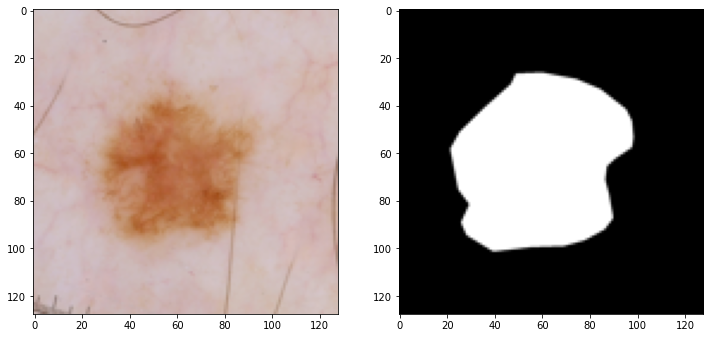

In [12]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(cv2.cvtColor(X_train[image_number], cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(y_train[image_number], cmap='gray')
plt.show()


In [13]:
###############################################################
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [14]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [15]:
def Unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs], name="Unet")
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef, 'accuracy'])
    #model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [jacard_coef, 'accuracy'])
    model.summary()
    
    return model

In [16]:
model=Unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                              

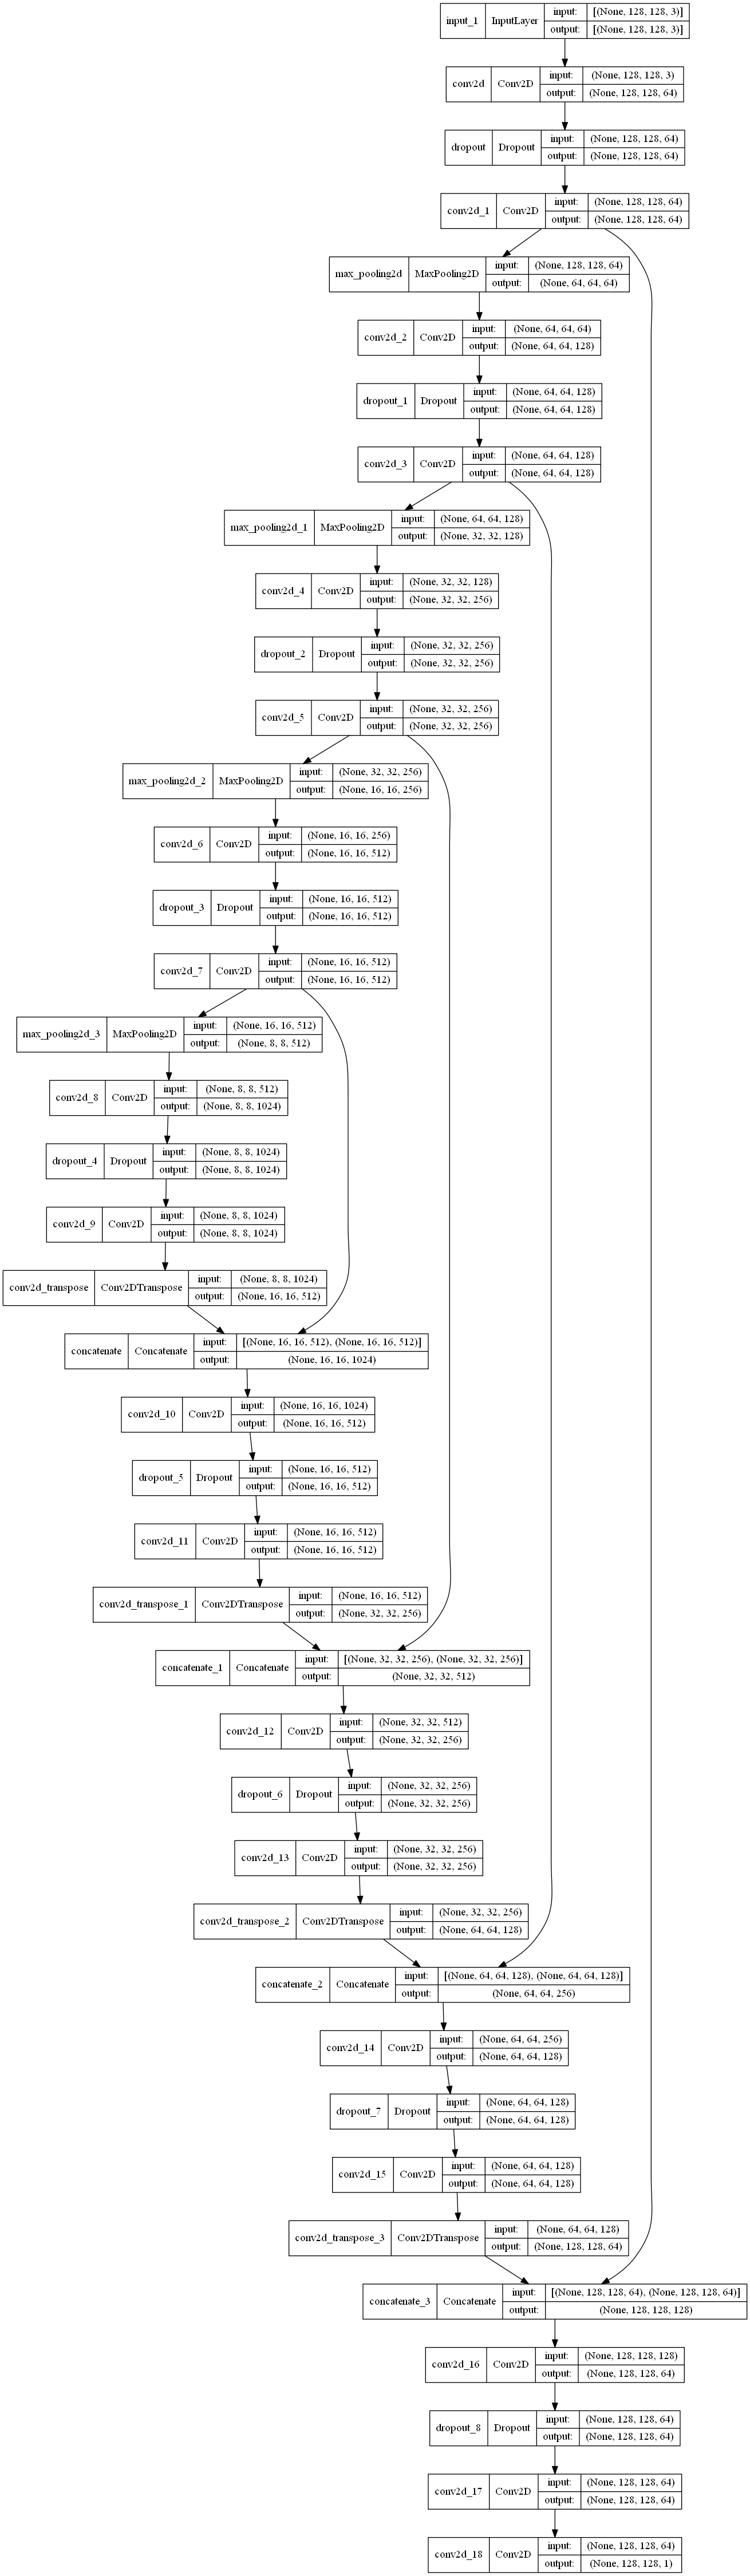

In [17]:
from keras.utils.vis_utils  import plot_model
plot_model(model, to_file='Unet_model_plot.png', show_shapes=True)


In [18]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [19]:
import tensorflow.compat.v2 as tf
#model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = [jacard_coef, 'accuracy'])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [jacard_coef, 'accuracy'])

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [20]:


model_history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test),
                    callbacks=[callback],
                    shuffle=False)
model.save('Unet_model.hdf5')

Epoch 1/100
51/51 [==============================] - 18s 157ms/step - loss: 0.5279 - jacard_coef: 0.2562 - accuracy: 0.7545 - val_loss: 0.4387 - val_jacard_coef: 0.3555 - val_accuracy: 0.8001 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 5s 106ms/step - loss: 0.4021 - jacard_coef: 0.3615 - accuracy: 0.8247 - val_loss: 0.3986 - val_jacard_coef: 0.3541 - val_accuracy: 0.8275 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 5s 106ms/step - loss: 0.3837 - jacard_coef: 0.3870 - accuracy: 0.8333 - val_loss: 0.3797 - val_jacard_coef: 0.3986 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 5s 105ms/step - loss: 0.3637 - jacard_coef: 0.4204 - accuracy: 0.8450 - val_loss: 0.3461 - val_jacard_coef: 0.4446 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 5s 106ms/step - loss: 0.3289 - jacard_coef: 0.4666 - accuracy: 0.8615 - val_loss: 0.3196 - val_jacard_coef: 0.4906 - val_accuracy:

51/51 [==============================] - 5s 107ms/step - loss: 0.0556 - jacard_coef: 0.8778 - accuracy: 0.9638 - val_loss: 0.2732 - val_jacard_coef: 0.7709 - val_accuracy: 0.9288 - lr: 4.9787e-05
Epoch 41/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0546 - jacard_coef: 0.8799 - accuracy: 0.9642 - val_loss: 0.2700 - val_jacard_coef: 0.7722 - val_accuracy: 0.9291 - lr: 4.5049e-05
Epoch 42/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0544 - jacard_coef: 0.8807 - accuracy: 0.9642 - val_loss: 0.2616 - val_jacard_coef: 0.7744 - val_accuracy: 0.9300 - lr: 4.0762e-05
Epoch 43/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0536 - jacard_coef: 0.8821 - accuracy: 0.9646 - val_loss: 0.2623 - val_jacard_coef: 0.7729 - val_accuracy: 0.9292 - lr: 3.6883e-05
Epoch 44/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0530 - jacard_coef: 0.8826 - accuracy: 0.9649 - val_loss: 0.2714 - val_jacard_coef: 0.7728 - val_ac

51/51 [==============================] - 5s 107ms/step - loss: 0.0474 - jacard_coef: 0.8944 - accuracy: 0.9672 - val_loss: 0.3205 - val_jacard_coef: 0.7724 - val_accuracy: 0.9282 - lr: 1.0078e-06
Epoch 80/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0474 - jacard_coef: 0.8946 - accuracy: 0.9672 - val_loss: 0.3211 - val_jacard_coef: 0.7725 - val_accuracy: 0.9282 - lr: 9.1188e-07
Epoch 81/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0471 - jacard_coef: 0.8951 - accuracy: 0.9674 - val_loss: 0.3215 - val_jacard_coef: 0.7725 - val_accuracy: 0.9282 - lr: 8.2510e-07
Epoch 82/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0473 - jacard_coef: 0.8947 - accuracy: 0.9671 - val_loss: 0.3215 - val_jacard_coef: 0.7725 - val_accuracy: 0.9282 - lr: 7.4658e-07
Epoch 83/100
51/51 [==============================] - 5s 107ms/step - loss: 0.0477 - jacard_coef: 0.8944 - accuracy: 0.9671 - val_loss: 0.3221 - val_jacard_coef: 0.7724 - val_ac

In [21]:
import pandas as pd
model_history_df = pd.DataFrame(model_history.history) 
with open('Unet_history_df.csv', mode='w') as f:
    model_history_df.to_csv(f)    

In [22]:
# evaluate model
_, jac, acc = model.evaluate(X_test, y_test)
print("Accuracy of Jacard Model is = ", (jac * 100.0), "%")

3/3 [==============================] - 6s 1s/step - loss: 0.3219 - jacard_coef: 0.7753 - accuracy: 0.9282
Accuracy of Jacard Model is =  77.52875685691833 %


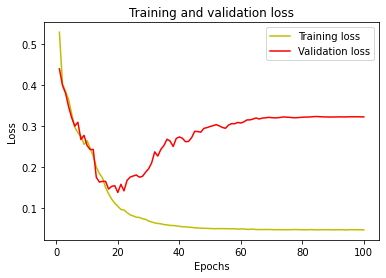

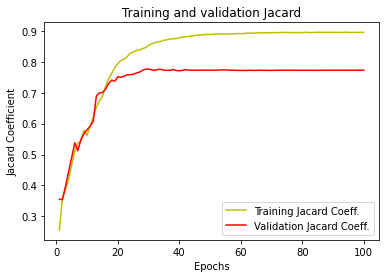

In [23]:
#plot the training and validation accuracy and loss at each epoch
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

jc = model_history.history['jacard_coef']
#acc = history.history['accuracy']
val_jc = model_history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'r', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()

In [24]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.7829190891925745


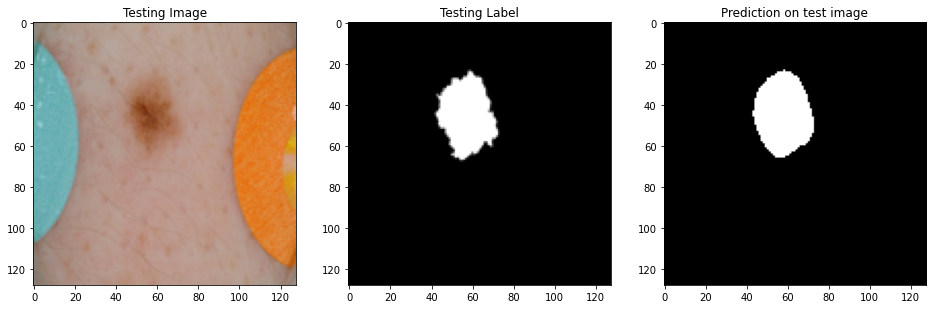

In [25]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,:][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
#prediction = (model.predict(test_img_input)[0,:,:,:] > 0.5).astype(np.uint8)
prediction = (model.predict(test_img_input)> 0.5).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(prediction[0], cmap='gray')
plt.show()